# A practical intro to Principal Component Analysis in Python
F. Balogh

2023/07/29

Principal component analysis (PCA) is a common first step to explore large datasets, to extract individual or mixed features that contribute the most to the variability of the data, and to perform dimensionality reduction to make further analysis computationally less expensive.

Suppose that we have $n$ samples with $p$ features observed for each sample point. In "omics" datasets it is common that the number of features is much larger than the number of samples. For simplicity, we assume that there is no missing data - if there is, we need to take extra measures before we can start the analysis of data.

Geometrically, we can imagine the $n$ samples as a cloud of points in $p$-dimensional space: the feature values of an individual sample can be thought of as the coordinates that describe the location of the sample point in $p$-space.

To illustrate the ideas that will follow, let us visualize a simple two-dimensional synthetic dataset using common Python modules. First the necessary modules will have to be imported; see the comments after the # sign for a short description for what each module does.

In [1]:
import pandas                   # module to load and manipulate data tables
import matplotlib.pyplot as plt # module to create versatile graphs
import seaborn                  # module to create stat-specific plots of data

We are now ready to read in our dataset from the external csv file *data.csv* by using the module Pandas.

In [2]:
Cloud=pandas.read_csv('data.csv') #import raw data from external file

No news is good news: if there is no error message, this means that the dataset is now loaded and ready for exploration.

The data is loaded into a **dataframe**, a tabular dataset with rows (samples) and columns (features).

 We can verify that all is good by printing out the dataset.

In [3]:
print(Cloud)

         F1      F2
0     2.526  -0.451
1     6.998   4.374
2     5.840   2.217
3    10.336   7.869
4     8.591   6.462
..      ...     ...
195   6.322   0.664
196  19.032  17.013
197   9.778   4.694
198  13.913  12.191
199  11.581  12.176

[200 rows x 2 columns]


Note that only a small portion of the dataset is printed, enough so that we can verify the structure and the labelling of the data.

In each module there are standard procedures to manipulate the related data structures and to find various properties of them. For example, we can read out the number of rows from a dataframe in the following way:

In [4]:
n = Cloud.shape[0]
print(n)

200


To get a visual representation, we can use the scatterplot command from the seaborn package:

<AxesSubplot:xlabel='F1', ylabel='F2'>

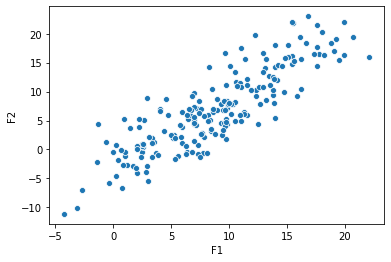

In [5]:
seaborn.scatterplot(data=Cloud, x="F1", y="F2")

Using a bit more sophisticated code, we can set the viewing window of the scatterplot:

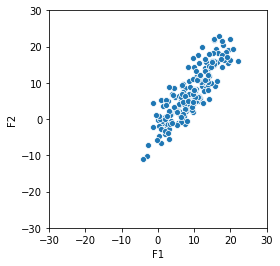

In [6]:
fig, ax = plt.subplots()
seaborn.scatterplot(data=Cloud, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-30, 30) # setting the range along the x-axis
ax.set_ylim(-30, 30) # setting the range along the y-axis
plt.show()

We can see in the plot above that the "center of mass" of the data off the origin (0,0). We can find the location of the geometric center of the sample by calculating the mean (average) of the features along the columns. This can be done as follows:

In [7]:
m=Cloud.mean(axis=0)
print(m)

F1    8.73337
F2    6.87638
dtype: float64


The following figure now shows the geometric location of the mean (red star).

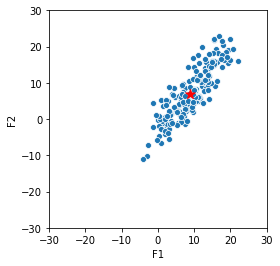

In [8]:
fig, ax = plt.subplots()
seaborn.scatterplot(data=Cloud, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-30, 30) # setting the range along the x-axis
ax.set_ylim(-30, 30) # setting the range along the y-axis
plt.scatter([m[0]],[m[1]],color="red", marker="*",s=100) # the center of mass plotted in red
plt.show()

We can center the dataset by subtracting the mean of the corresponding column from each entry in the data frame:

In [9]:
Cloud_centered = Cloud - Cloud.mean(axis=0)

           F1        F2
0    -6.20737  -7.32738
1    -1.73537  -2.50238
2    -2.89337  -4.65938
3     1.60263   0.99262
4    -0.14237  -0.41438
..        ...       ...
195  -2.41137  -6.21238
196  10.29863  10.13662
197   1.04463  -2.18238
198   5.17963   5.31462
199   2.84763   5.29962

[200 rows x 2 columns]


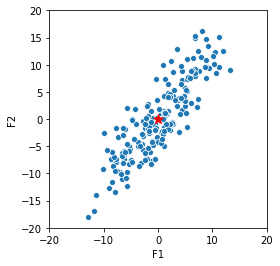

In [10]:
print(Cloud_centered)
fig, ax = plt.subplots()
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

We see that the source of variability cannot be identified with a single feature; the spread of the data points is maximized along a direction that is not aligned with either of the coordinate axes. This leads to the following idea: **search for a direction (i.e a linear combination of the features) along which the variance of the dataset is maximized**.

To do this, we set up the necessary mathematical formalism first. The data will be presented as an $n \times p$ Matrix $X$:
$$
X = \begin{bmatrix}
 x_{11} & x_{12} & \cdots & x_{1p} \cr
 x_{21} & x_{22} & \cdots & x_{2p} \cr
 \vdots & \vdots & \ddots & \vdots \cr
 x_{n1} & x_{n2} & \cdots & x_{np} 
\end{bmatrix}
$$
The rows correspond to samples, the columns are associated with the features observed.

From now on, we will assume that $X$ is centered (the column means are all equal to zero).

Note that in our pedagogical example $n$ is much larger than $p$. However, in many applications of principal component analysis it is common to have much more features than samples ($p >>n$).

To implement this matrix-based approach and use numerical arrays to represent our data, we import the module **numpy**:

In [11]:
import numpy as np

Now the centralized data frame can be converted to a matrix:

In [12]:
X=Cloud_centered.to_numpy()
print(X)

[[-6.207370e+00 -7.327380e+00]
 [-1.735370e+00 -2.502380e+00]
 [-2.893370e+00 -4.659380e+00]
 [ 1.602630e+00  9.926200e-01]
 [-1.423700e-01 -4.143800e-01]
 [ 7.416630e+00  1.247162e+01]
 [-8.517370e+00 -1.151538e+01]
 [ 3.497630e+00  1.293362e+01]
 [-1.970370e+00  2.359620e+00]
 [ 4.356630e+00  7.139620e+00]
 [ 1.800630e+00  1.408620e+00]
 [-1.013137e+01 -9.103380e+00]
 [-1.317370e+00  7.462000e-02]
 [-4.201370e+00  1.794620e+00]
 [ 2.275630e+00 -1.925380e+00]
 [ 5.756300e-01 -2.285380e+00]
 [ 1.440630e+00  9.726200e-01]
 [-5.523700e-01 -9.073800e-01]
 [ 1.018630e+00 -1.538380e+00]
 [ 8.046300e-01 -2.243380e+00]
 [ 5.846300e-01  1.002620e+00]
 [-3.605370e+00 -4.862380e+00]
 [-2.783370e+00 -3.039380e+00]
 [ 4.759630e+00  5.888620e+00]
 [ 3.556630e+00  2.357620e+00]
 [ 2.339630e+00  1.072662e+01]
 [ 1.098630e+00  1.434620e+00]
 [-1.598370e+00  2.106200e-01]
 [ 1.020630e+00 -5.018380e+00]
 [-6.371370e+00 -8.147380e+00]
 [-7.688370e+00 -7.969380e+00]
 [-7.732370e+00 -7.346380e+00]
 [ 2.557

In two dimensions, a direction can be parametrized by a vector
$$
\vec{u} = \begin{bmatrix}
u_1 \cr
u_2
\end{bmatrix}.
$$
We assume that the two entries of $\vec{u}$ are not zero simultaneously, that is, the length of $\vec{u}$ different from zero. 

Since a constant multiple of a vector gives the same direction, we can restrict ourselves to vectors of unit length; in terms of the entries of $\vec{u}$ this means
$$
u_1^2+u_2^2 =1.
$$
A data point - a vector $\vec{x}$, a row vector of the matrix $X$  - can be projected to the line spanned by the unit direction vector $\vec{u}$ by taking the product
$$\vec{x}\vec{u}$$
of $\vec{v}$ with $\vec{u}$ and measure it along the direction of $\vec{u}$.

For example,

In [13]:
alpha=2*np.pi/3
u=np.array([[np.cos(alpha)],[np.sin(alpha)]])
print(u)

[[-0.5      ]
 [ 0.8660254]]


In [14]:
X_projected=np.matmul(X,u)
print(X_projected)

[[-3.24201222]
 [-1.29943965]
 [-2.58845645]
 [ 0.05831914]
 [-0.28767861]
 [ 7.09242475]
 [-5.71392661]
 [ 9.45202848]
 [ 3.02867586]
 [ 4.00477729]
 [ 0.3195857 ]
 [-2.81807334]
 [ 0.72330782]
 [ 3.65487151]
 [-2.80524299]
 [-2.26701214]
 [ 0.12199863]
 [-0.50962913]
 [-1.84159116]
 [-2.34513907]
 [ 0.57597939]
 [-2.4082596 ]
 [-1.24049529]
 [ 2.71987951]
 [ 0.26344381]
 [ 8.11971042]
 [ 0.69310236]
 [ 0.98158727]
 [-4.85635957]
 [-3.87015305]
 [-3.05750053]
 [-2.49596671]
 [-1.69483628]
 [-2.03113921]
 [-1.54712541]
 [-2.66212172]
 [-6.07852819]
 [ 3.86878139]
 [-2.55799575]
 [-2.36559451]
 [-4.86796615]
 [ 5.99679165]
 [ 4.62108385]
 [-3.97264808]
 [ 3.35190396]
 [ 1.99707184]
 [-5.50509051]
 [-3.02685925]
 [-0.42201716]
 [-0.55482124]
 [-0.47960474]
 [-0.26583647]
 [ 2.33337988]
 [ 0.69326934]
 [-2.22221906]
 [-0.21369628]
 [ 0.85179963]
 [ 9.58109595]
 [-0.69527443]
 [-2.52632441]
 [ 3.52975787]
 [-5.33938322]
 [ 7.03485207]
 [ 1.99531964]
 [-0.78187205]
 [-3.65369296]
 [ 0.83352

In [15]:
X_proj_embedded=np.matmul(X_projected,np.transpose(u))
print(X_proj_embedded)

[[ 1.62100611 -2.80766494]
 [ 0.64971982 -1.12534775]
 [ 1.29422822 -2.24166904]
 [-0.02915957  0.05050585]
 [ 0.1438393  -0.24913698]
 [-3.54621237  6.14222   ]
 [ 2.85696331 -4.9484056 ]
 [-4.72601424  8.18569678]
 [-1.51433793  2.62291024]
 [-2.00238865  3.46823887]
 [-0.15979285  0.27676934]
 [ 1.40903667 -2.4405231 ]
 [-0.36165391  0.62640294]
 [-1.82743576  3.16521158]
 [ 1.4026215  -2.42941169]
 [ 1.13350607 -1.9632901 ]
 [-0.06099931  0.10565391]
 [ 0.25481457 -0.44135177]
 [ 0.92079558 -1.59486473]
 [ 1.17256954 -2.03095001]
 [-0.2879897   0.49881278]
 [ 1.2041298  -2.08561399]
 [ 0.62024765 -1.07430044]
 [-1.35993976  2.35548475]
 [-0.13172191  0.22814903]
 [-4.05985521  7.03187549]
 [-0.34655118  0.60024426]
 [-0.49079364  0.85007951]
 [ 2.42817978 -4.20573075]
 [ 1.93507653 -3.35165086]
 [ 1.52875027 -2.64787313]
 [ 1.24798335 -2.16157057]
 [ 0.84741814 -1.46777128]
 [ 1.0155696  -1.75901815]
 [ 0.7735627  -1.33984991]
 [ 1.33106086 -2.30546504]
 [ 3.0392641  -5.26415983]
 

The picture:

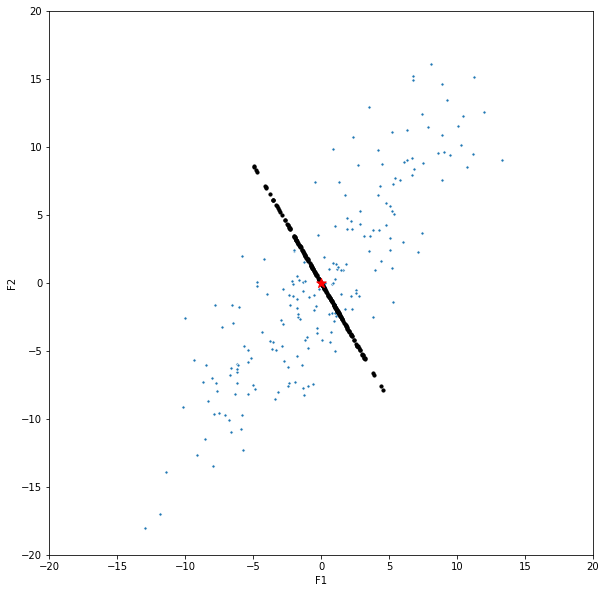

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
plt.scatter(X_proj_embedded[:,0],X_proj_embedded[:,1],color="black",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

Changing the direction of $\vec{u}$ gives different values of the spread of the data points:

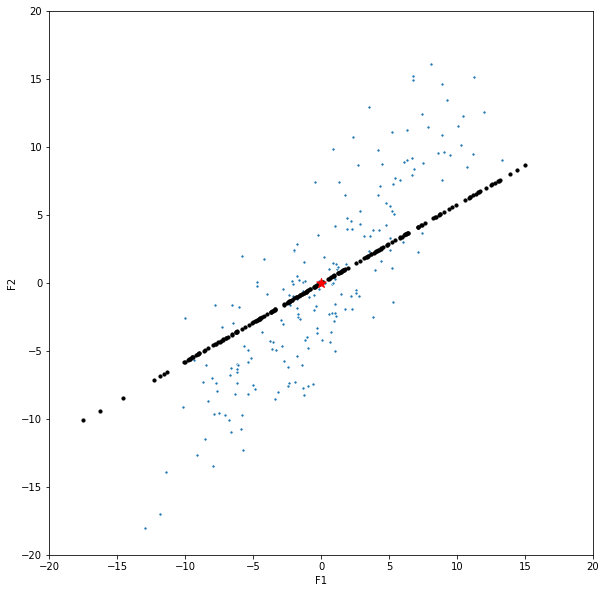

In [17]:
alpha=np.pi/6
u=np.array([[np.cos(alpha)],[np.sin(alpha)]])
X_projected=np.matmul(X,u)
X_proj_embedded=np.matmul(X_projected,np.transpose(u))

fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
plt.scatter(X_proj_embedded[:,0],X_proj_embedded[:,1],color="black",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

Here is the projection along the direction of the $x$ axis (feature F1):

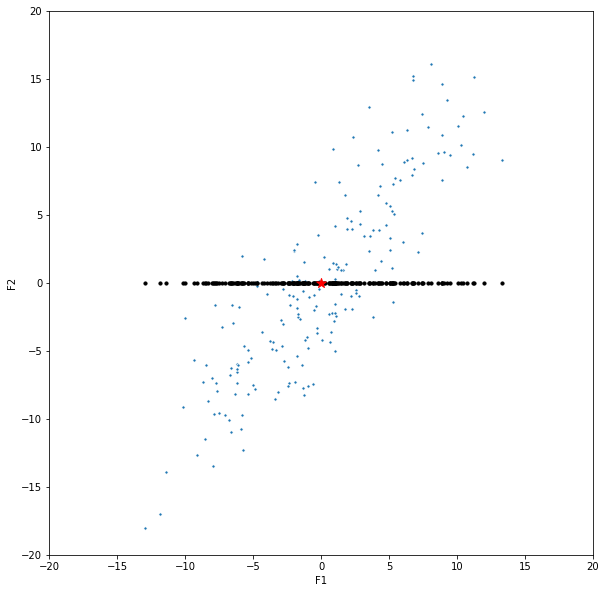

In [18]:
alpha=0
u=np.array([[np.cos(alpha)],[np.sin(alpha)]])
X_projected=np.matmul(X,u)
X_proj_embedded=np.matmul(X_projected,np.transpose(u))

fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
plt.scatter(X_proj_embedded[:,0],X_proj_embedded[:,1],color="black",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

Now, how do we find the direction (line) $\vec{u}$ along which the variability of the data is maximized?

We need to maximize the variance of the numerical sample $X\vec{u}$ in $\vec{u}$ under the constraint that $\vec{u}$ is of unit length. Check the following by matrix multiplication:
1. The condition $\vec{u}$ is of length $1$ is the same as $\vec{u}^{T}\vec{u}=1$.
2. Given the assumption that $X$ is centered, the (sample) variance of $X\vec{u}$ is equal to
$$
Var(X\vec{u}) = \frac{1}{n-1}\vec{u}^{T}X^{T}X\vec{u}.
$$

In terms of the (sample) covariance matrix
$$
\mathbf{S} = \frac{1}{n-1}X^{T}X,
$$
we can rewrite the variance as
$$
Var(X\vec{u}) = \vec{u}^{T}\mathbf{S}\vec{u}.
$$

To confirm that $\mathbf S$ is consistent with the built-in covariance matrix of $X$, we run the following check:

In [19]:
1/(n-1)*np.matmul(np.transpose(X),X)

array([[28.9791    , 31.77611273],
       [31.77611273, 47.22475763]])

In [20]:
Cloud.cov()

,F1,F2
F1,28.979100,31.776113
F2,31.776113,47.224758


Therefore we arrive at the following constrained optimization problem:
$$
\left\{
\begin{array}{l}
\vec{u}^{T}\mathbf{S}\vec{u} \to \text{Max},\\
\vec{u}^{T}\vec{u}=1.
\end{array}\right.
$$
This constrained optimization problem can be solved by the method of Lagrange multipliers of multivariate calculus (Calculus III). 

It turns out that the vectors that maximize the projected variance have to be satisfy an equation of the following form:
$$
\mathbf{S}\vec{u} = \lambda \vec{u},
$$
where $\lambda$ is a number. This means that $\vec{u}$ spans a direction along which multiplication by the matrix $\mathbf{S}$ reduces to a multiplication by a number. In other words, the line spanned by the vector $\vec{u}$ is invariant under the linear transformation associated with $\mathbf{S}$. Such vectors are called the **eigenvectors** of the matrix $\mathbf{S}$, and the associated value $\lambda$ is called the corresponding **eigenvalue** (see [this Wikipedia article](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) for details).

For example, the matrix
$$
A = \begin{bmatrix} 
1 & 6 \cr
7 & 2
\cr\end{bmatrix}
$$
has two eigenvalues, $\lambda=-5$ and $\lambda=8$:
$$
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
\begin{bmatrix}
1 \cr
-1
\end{bmatrix}
=
\begin{bmatrix}
-5 \cr
5
\end{bmatrix}
=
-5\cdot\begin{bmatrix}
1 \cr 
-1
\end{bmatrix}
\text{ and }
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
\begin{bmatrix}
6 \cr
7
\end{bmatrix}
=
\begin{bmatrix}
48 \cr
56
\end{bmatrix}
=
8\cdot\begin{bmatrix}
6 \cr 
7
\end{bmatrix}.
$$

The package numpy has a convenient linear algebra procedure **linalg.eig** for calculating the eigenvalues and the eigenvectors of a matrix:

In [21]:
A=np.array([[1,6],[7,2]])
np.linalg.eig(A)

(array([-5.,  8.]),
 array([[-0.70710678, -0.65079137],
        [ 0.70710678, -0.7592566 ]]))

Note that the procedure returns the array of eigenvalues and a matrix whose columns are the eigenvectors (these eigenvectors are listed in the same order as the eigenvalues).

Note also that the eigenvectors are determined only up to a constant since only the eigendirections matter; the Python procedure will return normalized eigenvalues (i.e. eigenvalues of length $1$). However, there is no canonical choice of sign either: if $\vec{u}$ is a normalized eigenvector then $=\vec{u}$ is also a normalized eigenvector, and they are both equally good as representatives of an invariant line of a linear transformation.

Some basic facts about eigenvalues and eigenvectors:
1. The eigenvalues of any matrix are the solutions of the polynomial equation
$$\det(A-\lambda I)=0,$$
where $\det$ is the determinant and $I$ stands for the identity matrix of matching the size of $A$.
2. A $k\times k$ matrix has exactly $k$ eigenvalues, but some of these values may be complex. For example, the matrix
$$
\begin{bmatrix} 
0 & 1 \cr
-1 & 0
\cr\end{bmatrix}
$$
has two complex eigenvalues $i$ and $-i$.
3. Eigenvectors corresponding to different eigenvalues are linearly independent. However, in case of multiple eigenvalues there may not be enough linearly independent eigenvectors to span a basis. For example the matrix
$$
\begin{bmatrix} 
3 & 1 \cr
0 & 3
\cr\end{bmatrix}
$$
has the eigenvalue $3$ with multiplicity $2$, but the corresponding eigenspace is one-dimesional: the only invariant line is spanned by the eigenvector 
$$
\begin{bmatrix} 
1 \cr
0 
\end{bmatrix}.
$$
4. If a $k\times k$ matrix $A$ has $k$ independent eigenvectors, then $A$ is **diagonalizable**, that is, in the eigenvector basis $A$ acts diagonally. More precisely, if $\lambda_1, \ldots, \lambda_k$ are the eigenvalues and $U$ is the matrix composed from the column eigenvectors following the same labelling, we have
$$
A U = U\mathop{diag}(\lambda_1, \ldots, \lambda_k),
$$
or
$$
A = U\mathop{diag}(\lambda_1, \ldots, \lambda_k)U^{-1}.
$$
For example, check that
$$
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}
=
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}
\begin{bmatrix} 
-5 & 0 \cr
0 & 8\cr
\end{bmatrix}
$$
or
$$
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
=
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}
\begin{bmatrix} 
-5 & 0 \cr
0 & 8\cr
\end{bmatrix}
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}^{-1}.
$$

Note that we are interested in the particular case of covariance matrices. These have the following special properties:
1. They are symmetric (a covariance matrix is equal to its transpose).
2. They are positive semidefinite (products of the form $\vec{u}\mathbf{S}\vec{u}$ are non-negative for all vectors $\vec{u}$.

The second property follows from the observation that $\vec{u}\mathbf{S}\vec{u}$ is the variance of a sample that is obtained from $X$ by taking linear combinations with coefficients given by the components of $\vec{u}$.

Luckily, a mathematical theorem guarantees the following for any matrix that satisfies the above properties:
1. All eigenvalues of $\mathbf{S}$ are non-negative real numbers.
2. The eigenvectors of $\mathbf{S}$ corresponding to different eigenvectors are orthogonal (not a given in the general case, only linear independence).
3. One can construct an orthonormal basis consisting of eigenvectors of $\mathbf{S}$.

This means that $\mathbf{S}= U \mathbf{D}U^{-1}$, where $\mathbf{D}$ is a diagonal matrix, and the columns of $U$ are orthogonal vectors. In particular, 
$$
U U^{T}=I \text{ and } U^{T}U=I
$$
and therefore $U^{-1}=U^{T}$.

This means that the variance function $\vec{u}^{T}u\mathbf{S}\vec{u}$ can be written as
$$
u^{T}\mathbf{S}\vec{u}=u^{T}U\mathbf{D}U^{T}\vec{u}.
$$

The key point to understand here is the geometric interpretation: if we change from the standard basis of the feature space to the orthonormal eigenbasis of $\mathbf{S}$, the covariance matrix becomes **diagonal**, i.e., the new basis vectors in the feature space are **uncorrelated**.

In our example below, we have the following matrices:

In [22]:
S=1/(n-1)*np.matmul(np.transpose(X),X)
print(S)

[[28.9791     31.77611273]
 [31.77611273 47.22475763]]


The eigenvalues and the eigenvectors can now be calculated by the linalg.eig routine:

In [23]:
eigenvalues, U= np.linalg.eig(S)
D=np.array([[eigenvalues[0],0],[0,eigenvalues[1]]])
print(D)
print(U)

[[ 5.04217464  0.        ]
 [ 0.         71.16168299]]
[[-0.79873327 -0.60168526]
 [ 0.60168526 -0.79873327]]


Now let's plot the eigendirections of $\mathbf{S}$. These will be parametric plots of straight lines, the parameter value $t$ will be taken from the following array:

In [24]:
t=np.linspace(-200,200,100)

These values will be used in two plt.plot routines, using the entries of the respective column of the matrix $U$:

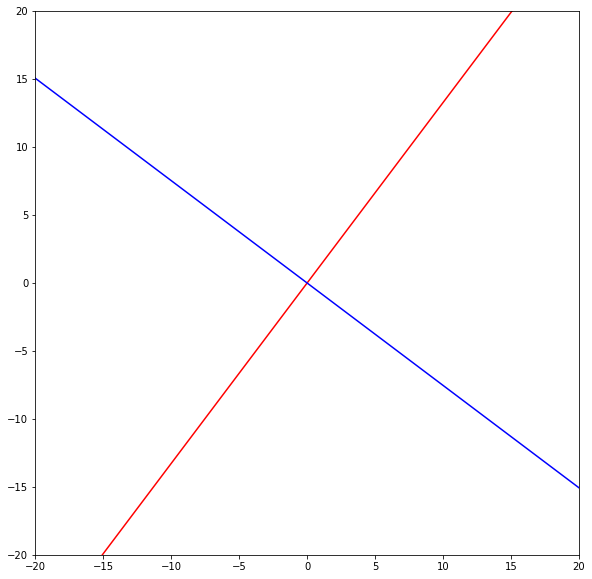

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.plot(t*U[0,1],t*U[1,1],color='red')
plt.plot(t*U[0,0],t*U[1,0],color='blue')
plt.show()

Now we plot the data points together with the newly found orthogonal lines:

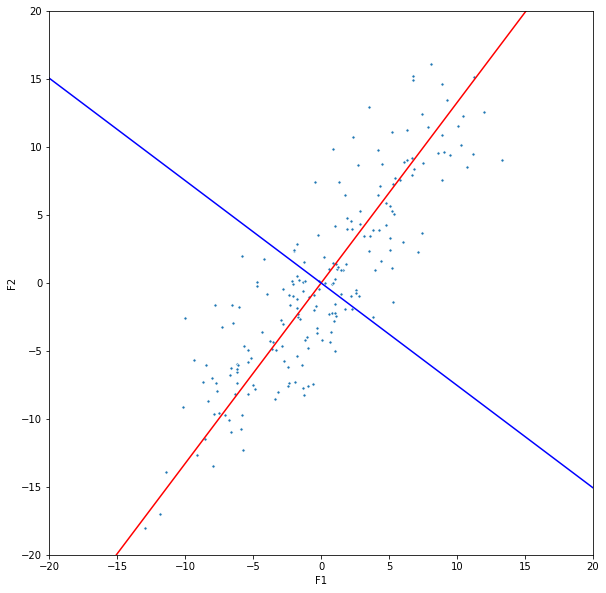

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.plot(t*U[0,1],t*U[1,1],color='red')
plt.plot(t*U[0,0],t*U[1,0],color='blue')
plt.show()

The geometric representation confirms what the algebra suggests: the direction along which the projected sample has the maximal variance is spanned by the eigenvector of the covariance matrix corresponding to the **largest eigenvalue**. We see also that the direction along which the variance of the projected sample is the smallest corresponds to the smallest eigenvalue.

In general, if we have $p$ features, all eigenvalues of the covariance matrix are distinct, and they are labelled in descending order
$$
\lambda_1 > \lambda_2 > \cdots > \lambda_p,
$$
we can rotate the coordinate system in the feature space in a unique way (up to sign), so that the $i$th coordinate is associated with a normalized eigenvector of $\lambda_i$. The directions of the new coordinate axes are called **principal directions**, and the corresponding coordinates are called **principal components**, labelled by the eigenvalue labels.

So in our graph above the red and the blue lines mark the first and the second principal directions, respectively.
The first principal component of any data point would determined from the dot product of the original feature vector with the eigenvector corresponding to the first (largest) eigenvalue. In our case, as
$$
u_1=\begin{bmatrix} 
1 \cr
0 
\end{bmatrix}.
$$
we have
$$
PC1 = (-0.60168526)\cdot F1 + (-0.79873327)\cdot F2,
$$
and
$$
PC2 = (-0.79873327)\cdot F1 + (0.60168526)\cdot F2.
$$

In general, the $i$th principal component is determined from the dot product of the original feature vector with the eigenvector corresponding to the $i$th eigenvalue $\lambda_i$.

The column vector $u_i$ of the matrix $U$ corresponding to the eigenvalue $\lambda_i$ is of length $1$ for all $i$. It is common practice to consider the projection of the original feature directions to the scaled vectors
$$
\frac{1}{\sqrt{\lambda_1}}\vec{u}_1, \dots, \frac{1}{\sqrt{\lambda_p}}\vec{u}_p.
$$

Note that, as our two-dimensional example shows below, the first principal direction does not coincide with the estimated regression line in general, with F1 as the independent variable and F2 as the dependent one. In fact, the principal components do not assume any ordering or hierarchy between variables, it is a "democratic" process in this sense. Principal directions and regression lines are both solutions of least square-type minimization problems, but they minimize for different geometric features, and hence their solutions are generally different.

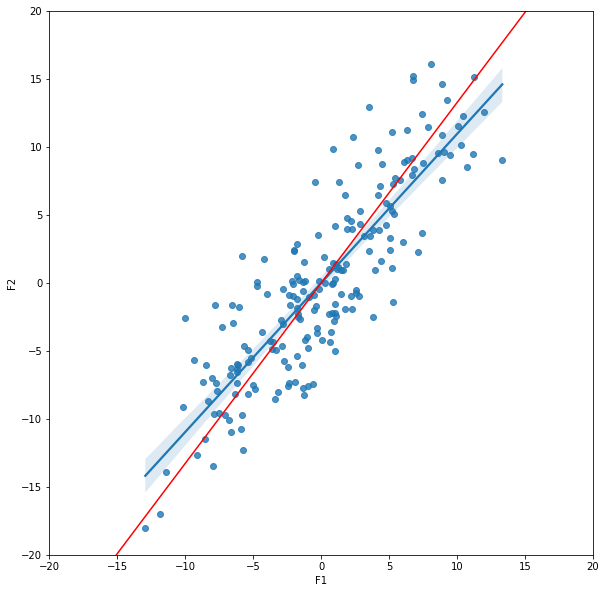

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.regplot(data=Cloud_centered, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.plot(t*U[0,1],t*U[1,1],color='red')
plt.show()

The total variance of the sample is the sum of the variances of the features. These individual variances are the diagonal elements of the original covariance matrix. If we change to principal components,
$$
\mathbf{S} = U \mathbf{D}U^{-1}
$$
we cannot expect the diagonal elements to be equal one-by-one, but one can prove by linear algebra that the sum of the diagonal elements are the same. In other words, the total variance is preserved, but it will be re-distributed into $p$ packets of descending order. Since the variances of the principal components are exactly the diagonal elements of the matrix $D$, we get an interesting interpretation of the eigenvalues $\lambda_i$: the ratio
$$
\frac{\lambda_i}{\lambda_1+\ldots+\lambda_p}
$$
gives the proportion of the total variance that $i$th principal carries/responsible for. Also, if we pick any subset $i_1,i_2,\dots,i_k$ of the principal components, these explain
$$
\frac{\lambda_{i_1}+\ldots+\lambda_{i_k}}{\lambda_1+\ldots+\lambda_p}
$$
of the total variance.

In our example, these values are

In [28]:
[eigenvalues[1]/sum(eigenvalues),eigenvalues[0]/sum(eigenvalues)]

[0.9338330787808931, 0.06616692121910701]

Here is how we can do the same with the module *scikit.learn* which has a full implementation of PCA:

In [44]:
X_original=Cloud.to_numpy() #raw data converted to a numpy array

from sklearn.decomposition import PCA #loading the module
pca = PCA() #setting up the principal component analysis routine
pca.fit(X_original) #performing PCA on X_original

print("Explained variance ratios:\n",pca.explained_variance_ratio_)

Explained variance ratios:
 [0.93383308 0.06616692]


Here is a scree plot:

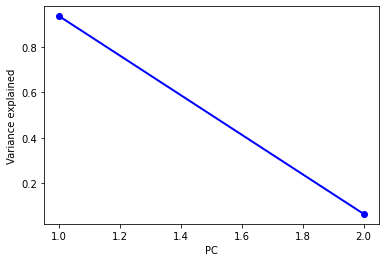

In [43]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('PC')
plt.ylabel('Explained variance')
plt.show()